# OLED Optimization with FourierFields


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from meep.materials import Ag as Ag

mp.verbosity(0)

SiO2 = mp.Medium(epsilon=2.13)    # 글래스의 굴절률 설정
GaN = mp.Medium(epsilon=6.18)   # OLED 유기층의 굴절률 설정
Al2O3 = mp.Medium(epsilon=3.17)    # 실리콘 질화물의 굴절률 설정
Air = mp.Medium(epsilon=1.0)    # 공기의 굴절률 설정

Basic setup

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 1/(0.45) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tSiO2 = 0.07    # passivation layer 두께
tAL = 0.1    # oxide side 두께
tAg = 0.07    # 은 층 두께
tGaN = 1   # GaN 층 두께
tPML = 0.1    # PML 두께
MtoPML = 0.1
MtoD = 0.5

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L + 2*tSiO2
design_region_height = 0.1

Sy = tPML + MtoPML + MtoD + design_region_height + tGaN + tAg   # Z 방향 전체 길이
Sx = L + 2*tSiO2 + + 2*tAL + 2*tPML                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(0.1,direction=mp.X),
                   mp.PML(0.1,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1
structure_weights = np.loadtxt(f'lastdesign.txt')
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, SiO2, grid_type="U_MEAN")
design_variables.update_weights(structure_weights)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=GaN,      # GaN 층
             size=mp.Vector3(L, tGaN),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*tGaN)),
    
    mp.Block(material=Ag,                       # 은 층
             size=mp.Vector3(L, tAg),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN - 0.5*tAg)),
    
    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - tPML - tAL - 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg) )),

    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + tPML + tAL + 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
    
    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),

    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 49

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -L/2 + (L)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN + 0.5*tAg,
                    z = 0
                )
            )
        )

sim = []

for i in range(src_num):
    sim.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[sources[i]],
                      extra_materials=[Ag],)
    )
                    

<Axes: xlabel='X', ylabel='Y'>

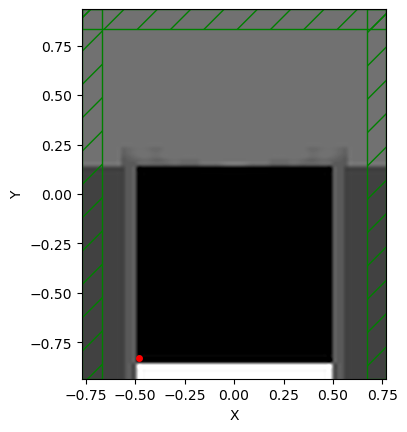

In [3]:
sim[0].plot2D()

In [4]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy - tPML - MtoPML), mp.Vector3(Sx - 2*tPML,0)

FourierFields_Ez = []
FourierFields_Hx = []
for i in range(src_num):
    FourierFields_Ez.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True))
    FourierFields_Hx.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Hx,yee_grid=True))
ob_list_Ez = []
ob_list_Hx = []
for i in range(src_num):
    ob_list_Ez.append(FourierFields_Ez[i])
    ob_list_Hx.append(FourierFields_Hx[i])

def J(fields_Ez, fields_Hx):
    return npa.real(npa.sum(fields_Ez[:,:]*(npa.real(fields_Hx[:,:])-npa.imag(fields_Hx[:,:])*1j)))

opt = []
for i in range(src_num):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J],
        objective_arguments=[ob_list_Ez[i], ob_list_Hx[i]],
        design_regions=[design_region],
        frequencies=[fcen],
        maximum_run_time=100,
    ))

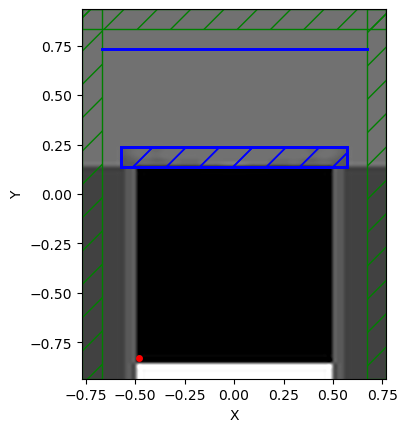

In [5]:
opt[0].plot2D(True)

In [6]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [7]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [8]:
evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0 = []
    dJ_du = []

    global numevl

    for i in range(src_num):
        f0_i, dJ_du_i = opt[i]([mapping(v, eta_i, beta)])
        f0.append(f0_i.flatten())
        dJ_du.append(dJ_du_i)

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=0)
        )  # backprop

    evaluation_history.append([np.max(np.real(f0[i])) for i in range(src_num)])

    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current f0 values: " + ", ".join(["f0_{}: {}".format(i, np.real(f0[i])) for i in range(src_num)]))

    return np.mean(f0)  # return the sum of the objective function values


In [9]:
import os

# 저장 폴더 생성
output_dir = "dipole_figures"
os.makedirs(output_dir, exist_ok=True)

src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -L/2 + (L)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN + 0.5*tAg,
                    z = 0
                )
            )
        )
ppopt =[]
for i in range(src_num):
    ppopt.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[source[i]],
                      extra_materials=[Ag],)
    )

for i in range(src_num):
    ppopt[i].run(until=200)
    ppopt[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.savefig(os.path.join(output_dir, f"Ez_field_distribution_{i}.png"))
    plt.close()

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

In [10]:
flux_srcbox_top =[0]*src_num
flux_srcbox_bot =[0]*src_num
flux_srcbox_left =[0]*src_num
flux_srcbox_right =[0]*src_num

flux_front =[0]*src_num


flux_total_srcbox =[0]*src_num
flux_total_front =[0]*src_num


FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

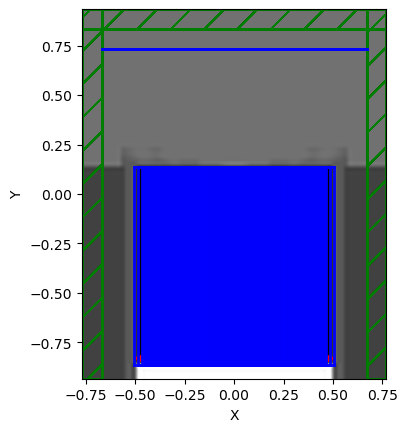

In [11]:

# 저장 폴더 생성
output_dir_1 = "wavelegnth_figures"
os.makedirs(output_dir_1, exist_ok=True)

for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[Ag],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-L/2 + (L)*((i+1)/(src_num+1)),y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-L/2 + (L)*((i+1)/(src_num+1)),y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-L/2 + (L)*((i+1)/(src_num+1)),0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN)), size=mp.Vector3(0,tGaN)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-L/2 + (L)*((i+1)/(src_num+1)),0.5*Sy - tPML - MtoPML - MtoD - design_region_height-0.5*(tGaN)), size=mp.Vector3(0,tGaN)))

    fluxbox_dpad = 0.05

    front = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy - tPML - MtoPML), size = mp.Vector3(Sx - 2*tPML,0,0)))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_front[i] = np.asarray(mp.get_fluxes(front))


    flux_freqs = mp.get_flux_freqs(front)

    flux_total_srcbox[i] = flux_srcbox_top[i] - flux_srcbox_bot[i] + flux_srcbox_right[i] - flux_srcbox_left[i]
    flux_total_front[i] = flux_front[i]

    wl = []
    gl = []
    wg = []

    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_front[i][d] / flux_total_srcbox[i][d])



    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Flux")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.savefig(os.path.join(output_dir_1, f"Fluxpower_{i}.png"))
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure




In [12]:
geometryo = [
    mp.Block(material=GaN,      # GaN 층
             size=mp.Vector3(L, tGaN),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*tGaN)),
    
    mp.Block(material=Ag,                       # 은 층
             size=mp.Vector3(L, tAg),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN - 0.5*tAg)),
    
    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - tPML - tAL - 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg) )),

    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + tPML + tAL + 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
    
    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),

    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
]

In [13]:
# 저장 폴더 생성
output_dir_2 = "origin_dipole_figures"
os.makedirs(output_dir_2, exist_ok=True)

ppopto =[]
for i in range(src_num):
    ppopto.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometryo,
                      sources=[source[i]],
                      extra_materials=[Ag],)
    )

for i in range(src_num):
    ppopt[i].run(until=200)
    ppopt[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.savefig(os.path.join(output_dir_2, f"Ez_field_distribution_{i}.png"))
    plt.close()

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

In [14]:
flux_srcbox_topo =[0]*src_num
flux_srcbox_boto =[0]*src_num
flux_srcbox_lefto =[0]*src_num
flux_srcbox_righto =[0]*src_num

flux_fronto =[0]*src_num


flux_total_srcboxo =[0]*src_num
flux_total_fronto =[0]*src_num


FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

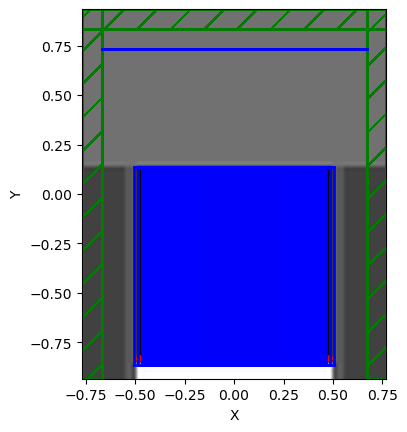

In [15]:

# 저장 폴더 생성
output_dir_3 = "origin_wavelegnth_figures"
os.makedirs(output_dir_3, exist_ok=True)

for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[Ag],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-L/2 + (L)*((i+1)/(src_num+1)),y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-L/2 + (L)*((i+1)/(src_num+1)),y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-L/2 + (L)*((i+1)/(src_num+1)),0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN)), size=mp.Vector3(0,tGaN)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-L/2 + (L)*((i+1)/(src_num+1)),0.5*Sy - tPML - MtoPML - MtoD - design_region_height-0.5*(tGaN)), size=mp.Vector3(0,tGaN)))

    fluxbox_dpad = 0.05

    front = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy - tPML - MtoPML), size = mp.Vector3(Sx - 2*tPML,0,0)))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_front[i] = np.asarray(mp.get_fluxes(front))


    flux_freqs = mp.get_flux_freqs(front)

    flux_total_srcboxo[i] = flux_srcbox_topo[i] - flux_srcbox_boto[i] + flux_srcbox_righto[i] - flux_srcbox_lefto[i]
    flux_total_fronto[i] = flux_fronto[i]

    wl = []
    gl = []
    wg = []

    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_front[i][d] / flux_total_srcbox[i][d])



    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Flux")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.savefig(os.path.join(output_dir_3, f"Fluxpower_{i}.png"))
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure

In [16]:
flux_srcbox_top_s =[0]*src_num
flux_srcbox_bot_s =[0]*src_num
flux_srcbox_left_s =[0]*src_num
flux_srcbox_right_s =[0]*src_num

flux_front_s =[0]*src_num


flux_total_srcbox_s =[0]*src_num
flux_total_front_s =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

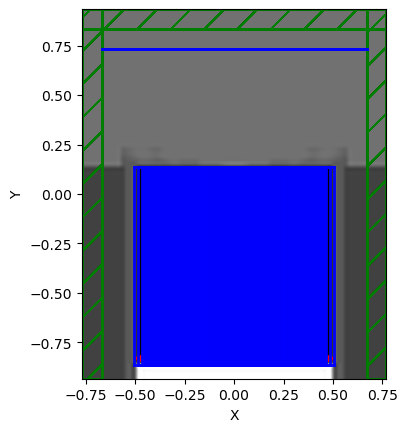

In [17]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[Ag],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-L/2 + (L)*((i+1)/(src_num+1)),y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-L/2 + (L)*((i+1)/(src_num+1)),y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-L/2 + (L)*((i+1)/(src_num+1)),0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN)), size=mp.Vector3(0,tGaN)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-L/2 + (L)*((i+1)/(src_num+1)),0.5*Sy - tPML - MtoPML - MtoD - design_region_height-0.5*(tGaN)), size=mp.Vector3(0,tGaN)))

    fluxbox_dpad = 0.05

    front = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy - tPML - MtoPML), size = mp.Vector3(Sx - 2*tPML,0,0)))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_front_s[i] = np.asarray(mp.get_fluxes(front))


    flux_freqs = mp.get_flux_freqs(front)

    flux_total_srcbox_s[i] = flux_srcbox_top_s[i] - flux_srcbox_bot_s[i] + flux_srcbox_right_s[i] - flux_srcbox_left_s[i]
    flux_total_front_s[i] = flux_front_s[i]

In [18]:
flux_srcbox_topo_s =[0]*src_num
flux_srcbox_boto_s =[0]*src_num
flux_srcbox_lefto_s =[0]*src_num
flux_srcbox_righto_s =[0]*src_num

flux_fronto_s =[0]*src_num


flux_total_srcboxo_s =[0]*src_num
flux_total_fronto_s =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

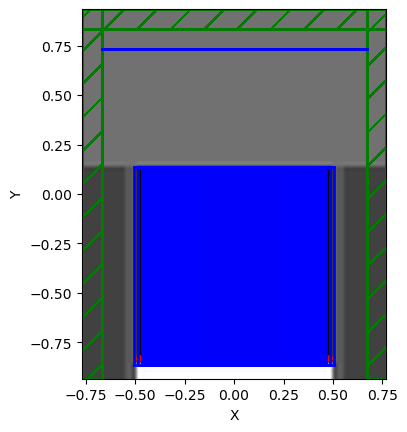

In [19]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[Ag],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-L/2 + (L)*((i+1)/(src_num+1)),y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-L/2 + (L)*((i+1)/(src_num+1)),y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-L/2 + (L)*((i+1)/(src_num+1)),0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN)), size=mp.Vector3(0,tGaN)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-L/2 + (L)*((i+1)/(src_num+1)),0.5*Sy - tPML - MtoPML - MtoD - design_region_height-0.5*(tGaN)), size=mp.Vector3(0,tGaN)))

    fluxbox_dpad = 0.05

    front = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy - tPML - MtoPML), size = mp.Vector3(Sx - 2*tPML,0,0)))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_fronto_s[i] = np.asarray(mp.get_fluxes(front))


    flux_freqs = mp.get_flux_freqs(front)

    flux_total_srcboxo_s[i] = flux_srcbox_topo_s[i] - flux_srcbox_boto_s[i] + flux_srcbox_righto_s[i] - flux_srcbox_lefto_s[i]    
    flux_total_fronto_s[i] = flux_fronto_s[i]

In [20]:
# 저장 폴더 생성
output_dir_4 = "Vs"
os.makedirs(output_dir_4, exist_ok=True)

wl = []
gl = []
wg = []
al = []
o_gl = []
o_wg = []
o_al = []
for d in range(src_num):
    wl = np.append(wl, d)
    gl = np.append(gl, flux_total_front_s[d] / flux_total_srcbox_s[d])
    o_gl = np.append(o_gl, flux_total_fronto_s[d] / flux_total_srcboxo_s[d])


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r-o", label="Flux")

    plt.plot(wl, o_gl, "r--o", label="o_Flux")


    
    # plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("dipole number")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(output_dir_4, f"FluxVs_{i}.png"))
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure